# Demand Pattern Analysis 

This notebook performs a detailed analysis of demand patterns in the NYC Taxi Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Import project modules
import sys
sys.path.append('..')
from src.data.data_loader import load_taxi_data
from src.features.demand_patterns import analyze_demand_patterns, visualize_demand_patterns

In [3]:
# Load processed data
df = pd.read_csv('../data/processed/processed_taxi_data.csv')

# Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

## 1. Analyze Demand Patterns

In [4]:
# Run demand pattern analysis
demand_data = analyze_demand_patterns(df)

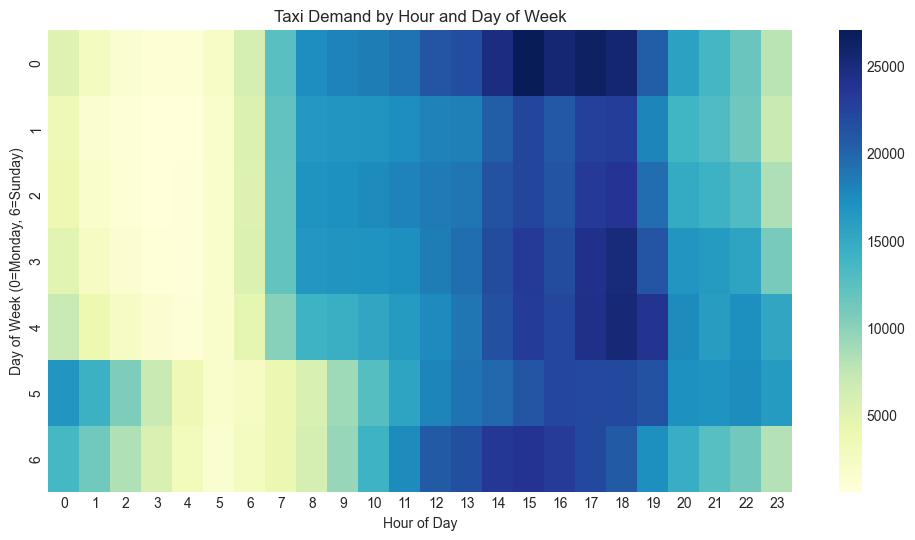

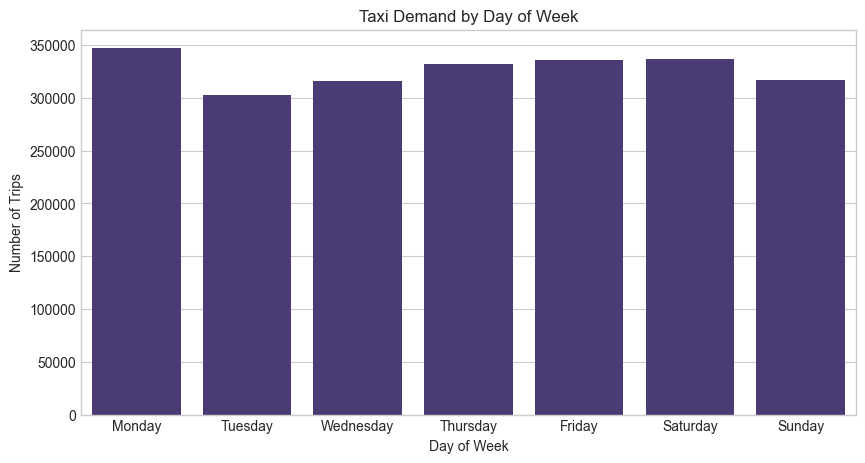

In [5]:
# Create visualizations
output_dir = Path('../output/demand_analysis')
output_dir.mkdir(parents=True, exist_ok=True)
visualize_demand_patterns(demand_data, save_dir=output_dir)

## 2. Peak Demand Analysis

In [6]:
# Examine peak demand periods
print("Top 10 highes demand periods: ")
display(demand_data['peak_demand'])

Top 10 highes demand periods: 


,day_of_week,hour,fare_amount,trip_distance,passenger_count,trip_count
15,0,15,12.902108,3.198291,1.428176,27080
17,0,17,12.419939,3.099174,1.396498,26444
18,0,18,12.098626,3.081084,1.369977,25707
16,0,16,12.723016,3.129478,1.412412,25540
114,4,18,11.505074,2.719062,1.413590,25327
90,3,18,11.426341,2.644603,1.374365,25184
14,0,14,12.939126,3.159046,1.414335,24736
113,4,17,12.057969,2.809656,1.412168,24359
89,3,17,12.179243,2.800803,1.381298,24254
115,4,19,11.468521,2.825690,1.444254,23966


In [7]:
# Calculate how much higher peak demand is compared to average
avg_demand = demand_data['hourly_demand']['trip_count'].mean()
peak_ratio = demand_data['peak_demand']['trip_count'].mean() / avg_demand

print(f"\nPeak periods have {peak_ratio:.2f}x more demand than average")


Peak periods have 1.85x more demand than average


## 3. Demand Volatility Analysis

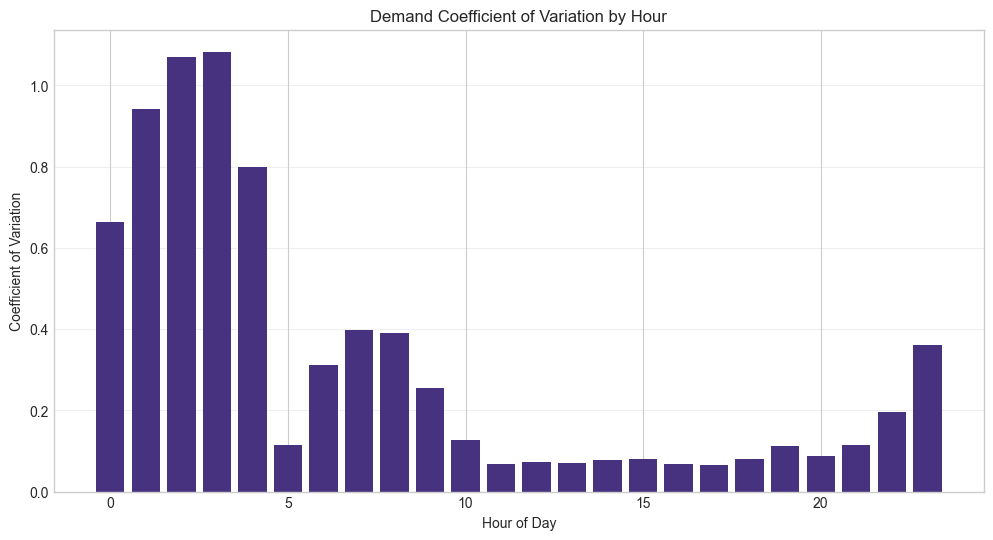

Hours with highest demand variability:


,hour,demand_std,demand_cv
3,3,2664.404803,1.083280
2,2,3993.937483,1.069164
1,1,5151.551056,0.942891
4,4,1254.093678,0.800096
0,0,5204.149526,0.664764


In [8]:
# Examine demand variability by hour
variability = demand_data['hourly_variability']

plt.figure(figsize=(12,6))
plt.bar(variability['hour'], variability['demand_cv'])
plt.title('Demand Coefficient of Variation by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Coefficient of Variation')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Identify hours with highest variability
most_variable = variability.sort_values('demand_cv', ascending=False).head(5)
print("Hours with highest demand variability:")
display(most_variable)

## 4. Geographic Demand Analysis

Top 20 pickup locations by demand: 


,Zone,Borough,trip_count
0,Upper East Side South,Manhattan,115447
1,Upper East Side North,Manhattan,113761
2,JFK Airport,Queens,97368
3,Midtown Center,Manhattan,83882
4,Penn Station/Madison Sq West,Manhattan,76712
5,Lincoln Square East,Manhattan,75756
6,Lenox Hill West,Manhattan,72743
7,Clinton East,Manhattan,72043
8,Murray Hill,Manhattan,71086
9,Midtown East,Manhattan,71065


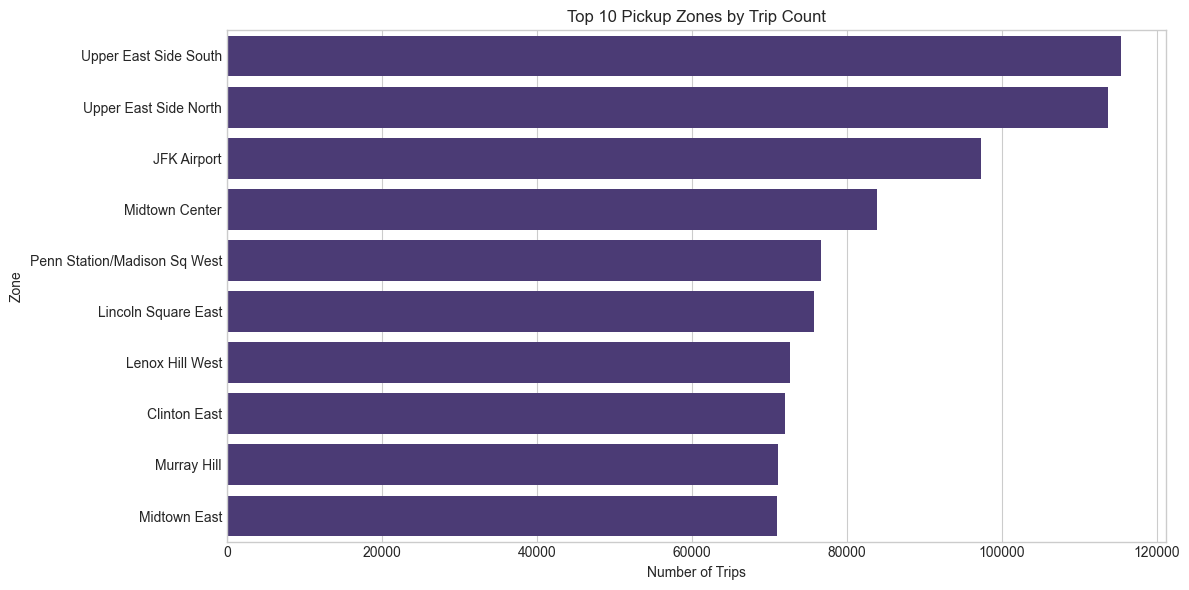

In [9]:
try:
    zone_lookup = pd.read_csv('../data/external/taxi_zone_lookup.csv')

    # Merge with location demand
    location_demand = demand_data['location_demand']
    location_demand = location_demand.merge(
        zone_lookup,
        left_on='PULocationID',
        right_on='LocationID'
    )

    # Display top 20 pickup locations
    print("Top 20 pickup locations by demand: ")
    display(location_demand[['Zone','Borough', 'trip_count']].head(20))
    
    # Plot top 10 zones
    plt.figure(figsize=(12,6))
    sns.barplot(y = 'Zone', x = 'trip_count', data=location_demand.sort_values('trip_count', ascending=False).head(10))
    plt.title('Top 10 Pickup Zones by Trip Count')
    plt.xlabel('Number of Trips')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Zone lookup file not found. Skipping geographic analysis.")

## 5. Time Series Patterns

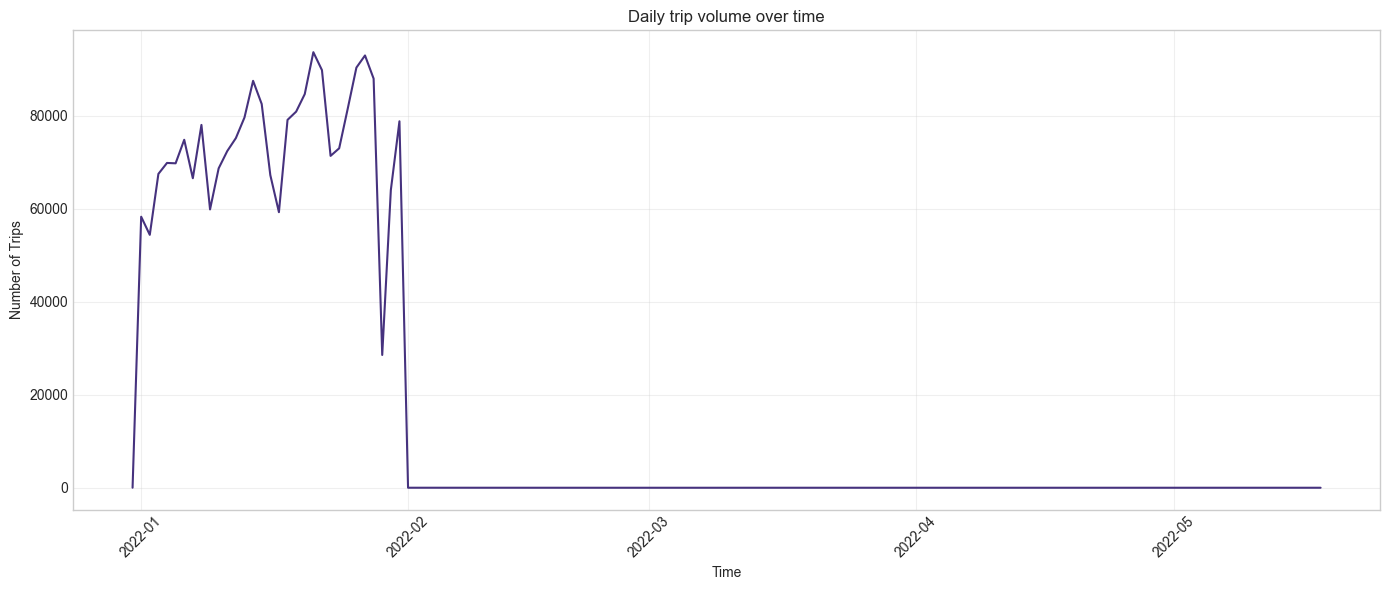

In [10]:
# Analyze pattern over the entire time period
# Group by Date 
df['date'] = df['pickup_datetime'].dt.date
daily_trips = df.groupby('date')['pickup_datetime'].count().reset_index()
daily_trips.columns = ['date','trip_count']

# Plot time series
plt.figure(figsize=(14,6))
plt.plot(daily_trips['date'], daily_trips['trip_count'])
plt.title('Daily trip volume over time')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.xticks(rotation = 45)
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

## 6. Export Demand Patterns for Modeling

In [14]:
# Export hourly demand patterns for use in the pricing model
hourly_demand = demand_data['hourly_demand']
hourly_demand.to_csv('../data/processed/hourly_demand_patterns.csv', index=False)

print("Demand patterns exported successfully.")

Demand patterns exported successfully.


## 7. Conclusions

Key findings from demand pattern analysis:

1. Weekday rush hours (7-9 AM and 5-7 PM) consistently show the highest demand
2. Weekend evenings (7-11 PM) also show significant demand peaks
3. Demand is most variable during early morning hours (3-5 AM)
4. Certain zones (particularly in Upper East Side South) show much higher demand than others
5. Demand follows clear daily and weekly cycles

These patterns suggest that an effective dynamic pricing strategy should:
- Increase prices during predictable high-demand periods
- Use more conservative pricing during highly variable periods
- Consider zone-specific pricing strategies where applicable
